In [1]:
import cv2 
import os 
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from collections import Counter
import random

import torch.nn as nn

import torch
import torch.nn.functional as F
from copy import deepcopy
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

**Project Scope**:
Build a CNN classifier from scratch, on your own data that works on your live stream.

1. Acquire dataset (Train and Validation):

   Grab frames from your camera for your classes classes.
   The amount of data to collect, is decided by you to reach good live performance.
2. Define pytorch dataset and data loader:
Define train and validation datasets and dataloader using **dset.ImageFolder(...)** with proper transforms. Also plot a few training and validation batches.

3. Define your CNN network (**must use pytorch, and build your own network**)
4. Train your network:

   Train the network, print training accuracy and loss per epoch, and also for the validation. **Save the best model to disk, and download it**.
   Plot a few validation batches, with their labels and their predictions.

5. Live model inference:
Connect to your laptop camera, grab frame by frame, and plot on the image the classification of the frame. If you did everything right, your model should work quite well.


Data set collection

In [11]:
# Define class names
classes = ['Mask', 'Sun-glasses', 'Nothing']

# Prompt user to select data type: training or validation
mode = input("Enter mode (train/val): ").strip().lower()
if mode not in ['train', 'val']:
    print("Invalid mode selected. Defaulting to 'train'.")
    mode = 'train'

# Create the base directory (data/train or data/val) and subdirectories for each class
base_dir = f"data_exp/{mode}"
for cls in classes:
    os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

# Open the default webcam
cap = cv2.VideoCapture(0)
print("Press 1 (Mask), 2 (Sun-glasses), or 3 (Nothing) to capture an image for the corresponding class.")
print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
    elif key in [ord('1'), ord('2'), ord('3')]:
        # Determine class index based on key press (1 -> class0, 2 -> class1, etc.)
        class_index = int(chr(key)) - 1
        folder = os.path.join(base_dir, classes[class_index])
        # Create a unique filename using current time in milliseconds
        filename = os.path.join(folder, f"{int(time.time()*1000)}.jpg")
        cv2.imwrite(filename, frame)
        print(f"Saved image to {filename}")

cap.release()
cv2.destroyAllWindows()

Enter mode (train/val):  q


Invalid mode selected. Defaulting to 'train'.
Press 1 (Mask), 2 (Sun-glasses), or 3 (Nothing) to capture an image for the corresponding class.
Press 'q' to quit.


In [ ]:
# Define transformations: resize images to 224x224 and convert to tensor
# Custom Transform for Adding Gaussian Noise
# Training transforms: all PIL ops first, then Tensor ops
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomCrop(224, padding=10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

# Validation (unchanged)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

# Create datasets
train_data = dset.ImageFolder(root='data/train', transform=train_transforms)
val_data = dset.ImageFolder(root='data/val', transform=val_transforms)

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

# Print dataset sizes and class mappings
print(f"Number of training images: {len(train_data)}")
print(f"Number of validation images: {len(val_data)}")
print("Train class mapping:", train_data.class_to_idx)
print("Validation class mapping:", val_data.class_to_idx)

def plot_batch_with_labels(images, labels, class_names, title="Batch Images"):
    # Convert images from tensor to numpy array and change from (N, C, H, W) to (N, H, W, C)
    images = images.numpy().transpose((0, 2, 3, 1))
    
    batch_size = images.shape[0]
    cols = min(batch_size, 8)  # Limit to 8 columns per row for clarity
    rows = (batch_size + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    # Flatten axes for easy iteration, in case there's only one row or one image
    if rows * cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(batch_size):
        axes[i].imshow(np.clip(images[i], 0, 1))
        # Get label name using the class_names list
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')

    # Hide any extra subplots if the grid is larger than the batch size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title)
    plt.show()

# Plot a training batch with labels
train_batch_images, train_batch_labels = next(iter(train_loader))
plot_batch_with_labels(train_batch_images, train_batch_labels, train_data.classes, title="Training Batch with Labels")

# Plot a validation batch with labels
val_batch_images, val_batch_labels = next(iter(val_loader))
plot_batch_with_labels(val_batch_images, val_batch_labels, val_data.classes, title="Validation Batch with Labels")

# Function to display a grid of images with a title
def imshow(img, title):
    # Convert the tensor image to numpy format
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title(title)
    plt.axis('off')

# Plot a few training batches with their labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = make_grid(images, nrow=8)
plt.figure(figsize=(12, 8))
imshow(img_grid, "Training Batch")
plt.show()

# Plot a few validation batches with their labels
dataiter_val = iter(val_loader)
images_val, labels_val = next(dataiter_val)
img_grid_val = make_grid(images_val, nrow=8)
plt.figure(figsize=(12, 8))
imshow(img_grid_val, "Validation Batch")
plt.show()

val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Print the shape and pixel statistics for the training batch
print("Training Batch shape:", images.shape)
print("Min pixel value:", images.min().item())
print("Max pixel value:", images.max().item())
print("Average pixel value:", images.mean().item())

# Print dataset distributions to check balance
print("Training data distribution:", Counter(train_data.targets))
print("Validation data distribution:", Counter(val_data.targets))

In [3]:
class LiveClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(LiveClassifier, self).__init__()
        # Convolutional Block 1: From 3 to 32 channels.
        # Input: 224x224 -> After MaxPool: 112x112
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
#            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3) # Probability of dropping neurons
        )
        
        # Convolutional Block 2: From 32 to 64 channels.
        # 112x112 -> After MaxPool: 56x56
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3)
        )
        
        # Convolutional Block 3: From 64 to 128 channels.
        # 56x56 -> After MaxPool: 28x28
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3) 
        )
        
        # Convolutional Block 4: From 128 to 256 channels.
        # 28x28 -> After MaxPool: 14x14
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
#            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3)
        )
        
        # Global Average Pooling: Converts [B, 256, 14, 14] to [B, 256, 1, 1]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dropout to help with regularization
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layer: Maps 256 features to 3 class scores.
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)  # [B, 32, 112, 112]
        x = self.conv2(x)  # [B, 64, 56, 56]
        x = self.conv3(x)  # [B, 128, 28, 28]
        x = self.conv4(x)  # [B, 256, 14, 14]
        x = self.gap(x)    # [B, 256, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten to [B, 256]
        x = self.dropout(x)
        x = self.fc(x)           # [B, num_classes]
        return x

# Instantiate the model (for 3 classes)
model = LiveClassifier(num_classes=3)
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LiveClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (gap): AdaptiveA

In [4]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# ------------------------------
# Layer-wise Learning Rate Adjustment:
# For example, using a smaller LR for early layers (conv1 & conv2) and a higher LR for later layers.
optimizer = optim.Adam([
    {'params': model.conv1.parameters(), 'lr': 0.0005},
    {'params': model.conv2.parameters(), 'lr': 0.0005},
    {'params': model.conv3.parameters(), 'lr': 0.0005},
    {'params': model.conv4.parameters(), 'lr': 0.0005},
    {'params': model.gap.parameters(),   'lr': 0.001},
    {'params': model.fc.parameters(),    'lr': 0.001},
    # model.dropout has no learnable parameters so it can be omitted or included
], weight_decay=1e-4)
# ------------------------------

# Define a learning rate scheduler (StepLR: reduce LR by factor 0.5 every 5 epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Scheduler to adjust learning rate
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)
#scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=10)

# Training settings
num_epochs = 10  # Increase epochs if needed
patience = 3     # Early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None  # Variable to store the best model state

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_train_loss = running_loss / len(train_data)
    epoch_train_acc = running_corrects.double() / len(train_data)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc.item())
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    
    epoch_val_loss = val_loss / len(val_data)
    epoch_val_acc = val_corrects.double() / len(val_data)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    print("-" * 30)

    # Scheduler step (update learning rate)
    scheduler.step()  # Adjust the learning rate as scheduled
    #scheduler.step(epoch_val_loss)  # When using optim.lr_scheduler.ReduceLROnPlateau
    
    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_acc = epoch_val_acc
        patience_counter = 0
        best_model_state = deepcopy(model.state_dict())
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save the best model state once at the end
if best_model_state is not None:
    torch.save(best_model_state, 'cnn_best_model_DV_project_improvements_3.pth')
    print(f"Best Model Performance: Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.4f}")
    print("Best model saved to cnn_best_model_DV_project_improvements_3.pth")
else:
    print("No improvement observed during training.")


Epoch 1/10
Train Loss: 1.0833, Train Acc: 0.3826
Val Loss: 1.0388, Val Acc: 0.3929
------------------------------
Epoch 2/10
Train Loss: 0.9851, Train Acc: 0.5098
Val Loss: 0.9572, Val Acc: 0.4580
------------------------------
Epoch 3/10
Train Loss: 0.8582, Train Acc: 0.6083
Val Loss: 0.7112, Val Acc: 0.7218
------------------------------
Epoch 4/10
Train Loss: 0.6351, Train Acc: 0.7445
Val Loss: 0.4062, Val Acc: 0.8925
------------------------------
Epoch 5/10
Train Loss: 0.4482, Train Acc: 0.8349
Val Loss: 0.2285, Val Acc: 0.9397
------------------------------
Epoch 6/10
Train Loss: 0.3016, Train Acc: 0.8985
Val Loss: 0.1630, Val Acc: 0.9601
------------------------------
Epoch 7/10
Train Loss: 0.2534, Train Acc: 0.9150
Val Loss: 0.1379, Val Acc: 0.9643
------------------------------
Epoch 8/10
Train Loss: 0.2179, Train Acc: 0.9269
Val Loss: 0.1012, Val Acc: 0.9751
------------------------------
Epoch 9/10
Train Loss: 0.1907, Train Acc: 0.9389
Val Loss: 0.0893, Val Acc: 0.9741
-----

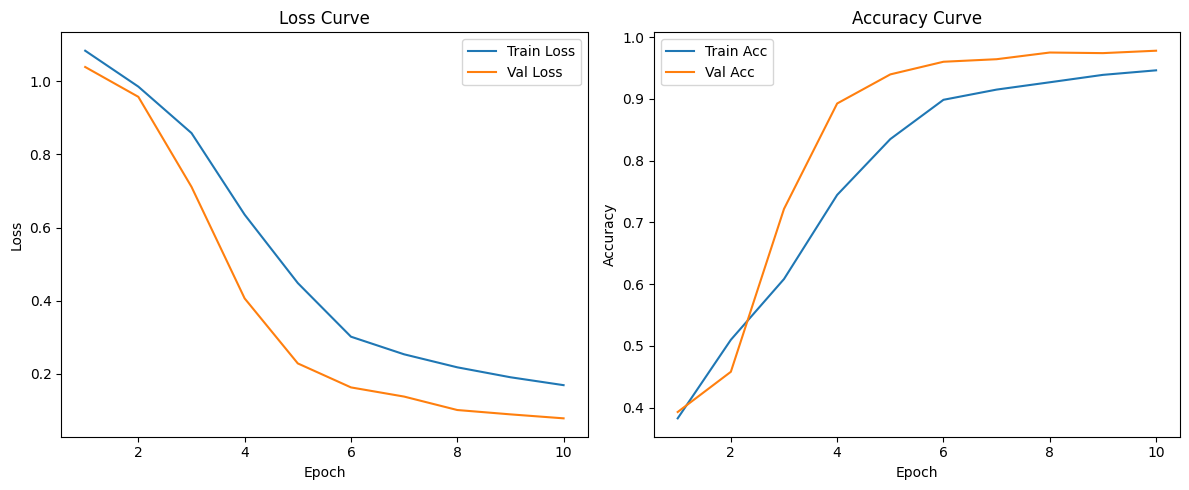

In [5]:
# Plot Loss and Accuracy Curves (Train + Validation)
epochs_range = range(1, len(train_losses) + 1)

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Plot a Few Batches with Their Labels and Predictions
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
def plot_batch_with_labels_and_preds(images, labels, preds, class_names, title="Batch Images"):
    # Convert tensor images to numpy and rearrange to (N, H, W, C)
    images = images.numpy().transpose((0, 2, 3, 1))
    batch_size = images.shape[0]
    cols = min(batch_size, 8)
    rows = (batch_size + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    if rows * cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(batch_size):
        axes[i].imshow(np.clip(images[i], 0, 1))
        gt_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        axes[i].set_title(f"GT: {gt_label}\nPred: {pred_label}")
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title)
    plt.show()

# Get one batch from the validation loader
val_batch_images, val_batch_labels = next(iter(val_loader))
model.eval()
with torch.no_grad():
    inputs = val_batch_images.to(device)
    outputs = model(inputs)
    _, val_preds = torch.max(outputs, 1)

plot_batch_with_labels_and_preds(val_batch_images, val_batch_labels, val_preds.cpu(), val_data.classes, title="Validation Batch: GT vs Predictions")


In [7]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
           Dropout-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
           Dropout-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
             ReLU-10          [-1, 128, 56, 56]               0
        MaxPool2d-11          [-1, 128, 28, 28]               0
          Dropout-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
             ReLU-14          [-1, 256,

C:\Users\sy020\.conda\envs\env_torch\lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


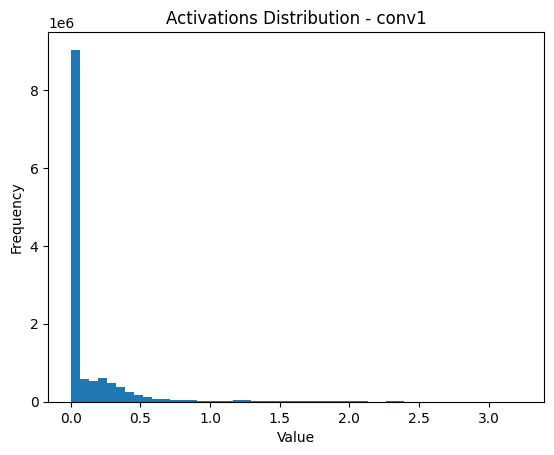

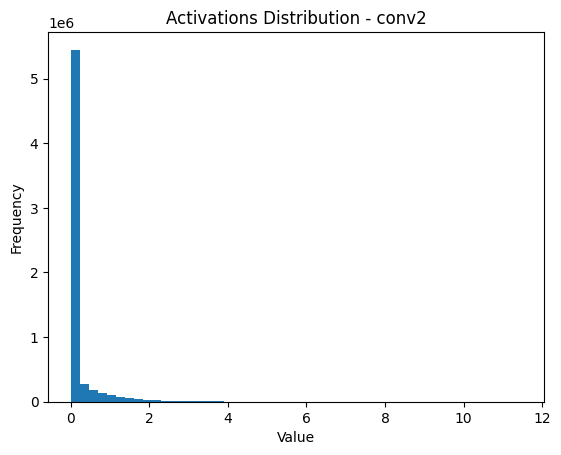

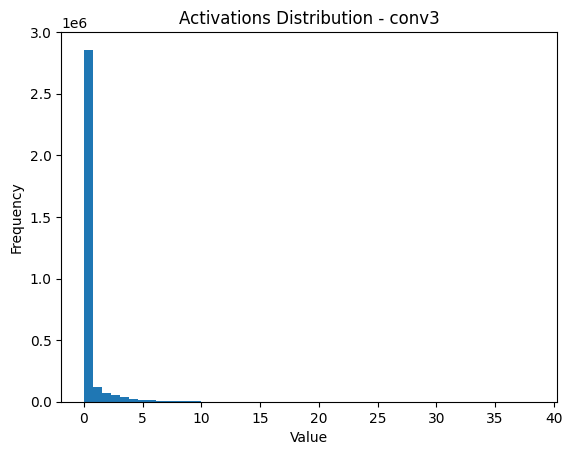

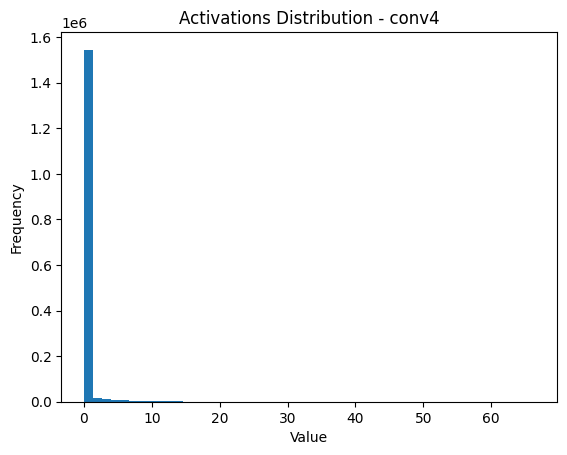

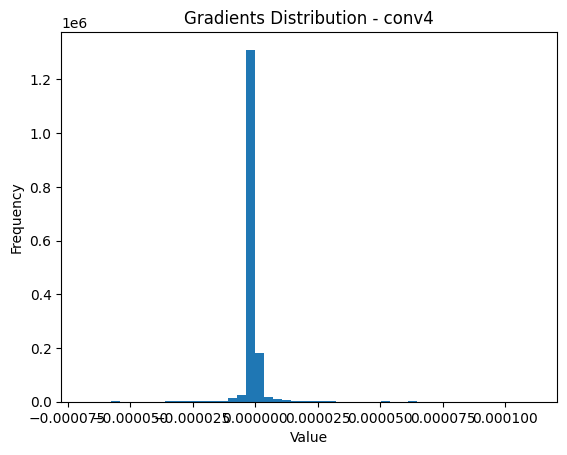

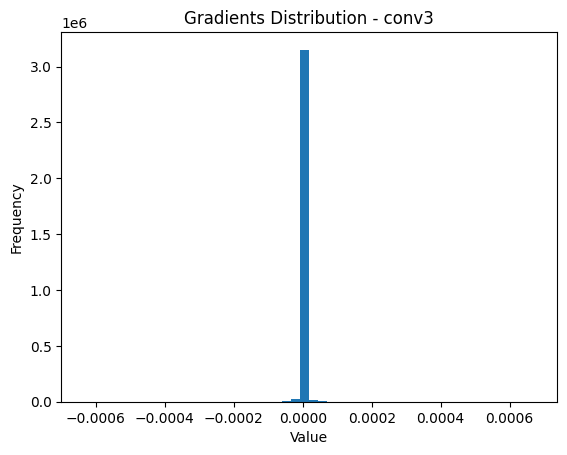

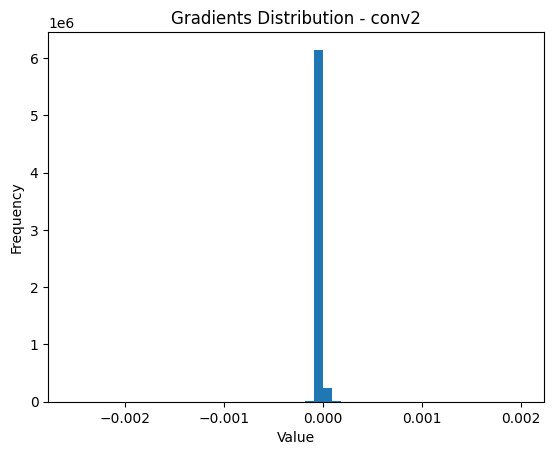

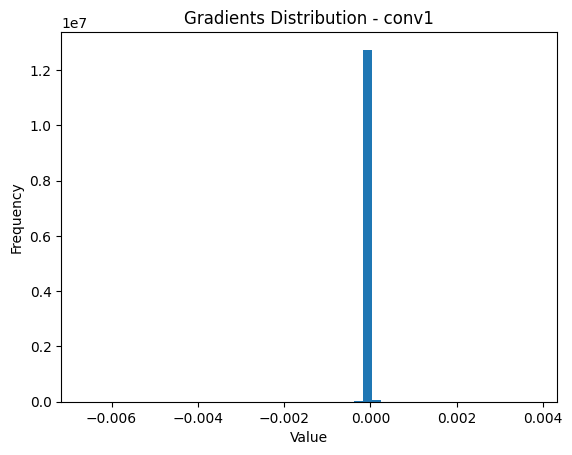

In [8]:
# Visualize Activations and Gradients
#
# This cell registers hooks on the convolutional layers to capture
# the activations (forward pass) and gradients (backward pass). Then,
# it uses a sample batch from the validation set to visualize their distributions.

activations = {}
gradients = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

def get_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach()
    return hook

# Register hooks on conv layers (forward)
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))
model.conv4.register_forward_hook(get_activation('conv4'))

# Register hooks on conv layers (backward)
model.conv1.register_backward_hook(get_gradient('conv1'))
model.conv2.register_backward_hook(get_gradient('conv2'))
model.conv3.register_backward_hook(get_gradient('conv3'))
model.conv4.register_backward_hook(get_gradient('conv4'))

# Use a single batch from the validation loader for visualization
sample_images, sample_labels = next(iter(val_loader))
sample_images = sample_images.to(device)
sample_labels = sample_labels.to(device)

model.train()  # Enable gradient computation
outputs = model(sample_images)
loss = criterion(outputs, sample_labels)
loss.backward()

import matplotlib.pyplot as plt

def plot_tensor_distribution(tensor, title):
    tensor = tensor.cpu().numpy().flatten()
    plt.hist(tensor, bins=50)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Plot distributions for activations and gradients
for layer in activations:
    plt.figure()
    plot_tensor_distribution(activations[layer], f"Activations Distribution - {layer}")

for layer in gradients:
    plt.figure()
    plot_tensor_distribution(gradients[layer], f"Gradients Distribution - {layer}")


Classification Report:
              precision    recall  f1-score   support

        Mask       0.99      0.98      0.99      3077
     Nothing       0.99      0.96      0.97      3077
 Sun-glasses       0.96      1.00      0.98      3077

    accuracy                           0.98      9231
   macro avg       0.98      0.98      0.98      9231
weighted avg       0.98      0.98      0.98      9231

Confusion Matrix:
[[3014   28   35]
 [  23 2952  102]
 [   4   11 3062]]


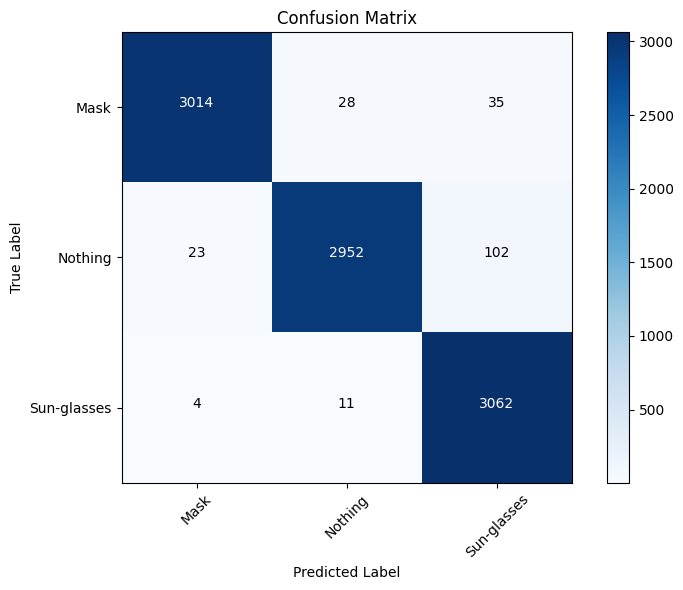

In [9]:
# Set the model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Loop over the validation set and collect predictions and true labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Print classification report containing precision, recall, and F1-score per class
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_data.classes, zero_division=0))

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set the tick marks and labels using class names from val_data
tick_marks = np.arange(len(val_data.classes))
plt.xticks(tick_marks, val_data.classes, rotation=45)
plt.yticks(tick_marks, val_data.classes)

# Annotate each cell in the confusion matrix with the numeric counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

# Label the axes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [10]:
# Load the trained model for inference
#model = LiveClassifier(num_classes=len(train_data.classes))
model = LiveClassifier(num_classes=len(train_data.classes))
model_path = 'cnn_best_model_DV_project_improvements_3.pth'  # if os.path.exists('cnn_model_best.pth') else 'cnn_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Define transformation for live inference (same as training)
live_transform = transforms.Compose([
#    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
#    transforms.CenterCrop(224),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

cap = cv2.VideoCapture(0)
print("Starting live prediction. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break
    
    # Convert the frame from BGR (OpenCV format) to RGB (PIL format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_frame)
    
    # Apply transformation and add batch dimension
    input_tensor = live_transform(pil_img).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred = torch.max(probs, 1)
    
    class_idx = pred.item()
    class_name = train_data.classes[class_idx]
    confidence_percentage = confidence.item() * 100
    
    # Overlay prediction and confidence on the frame
    cv2.putText(frame, f"Prediction: {class_name} ({confidence_percentage:.1f}%)", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow("Live Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Starting live prediction. Press 'q' to quit.


extra:

In [ ]:
#Lower means subtract less from each channel, so pixel values stay higher (brighter).

#Larger stds divide by a bigger number, so you shrink the range less aggressively.